# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [5]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_ind = np.where(cifar10_labels=='bird')
deer_ind = np.where(cifar10_labels=='deer')
truck_ind = np.where(cifar10_labels=='truck')

In [6]:
remove_num = 2500
counter = 0
train_num = len(y_train) - remove_num * 3 # for 3 classes
x_train_removed =  np.zeros(x_train.shape)[:train_num]
y_train_removed =  np.zeros(y_train.shape)[:train_num]

# bird, deer, truck labeld data is removed by 2500
bird_limit, deer_limit, truck_limit = 0, 0, 0
for i, label in enumerate(y_train):
    if (label != bird_ind) & (label != deer_ind) & (label != truck_ind):
        x_train_removed[counter] = x_train[i]
        y_train_removed[counter] = y_train[i]
        counter += 1
    else:
        if label == bird_ind:
            if bird_limit < 2500:
                bird_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == deer_ind:
            if deer_limit < 2500:
                deer_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue
        if label == truck_ind:
            if truck_limit < 2500:
                truck_limit += 1
                x_train_removed[counter] = x_train[i]
                y_train_removed[counter] = y_train[i]
                counter += 1
                continue
            else: continue

y_train_removed = np.array(y_train_removed, dtype='uint8')

In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500, 1)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0    5000
1    5000
3    5000
5    5000
6    5000
7    5000
8    5000
2    2500
4    2500
9    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

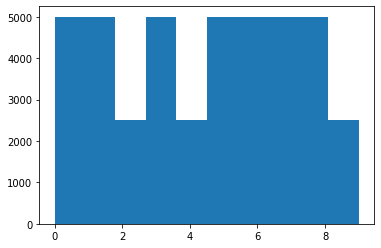

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## AutoEncoder

#### Define AE 01 Hyperparamters

In [10]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

In [43]:
# Hyperparmeter Optimization
def objective1(trial):
    print("Optimize Start")
    
    # filter size
    k_size = trial.suggest_categorical('ksize', [3, 5, 7]) # 3 or 5 or 7

    # batch size
#     batch_size = trial.suggest_categorical('batchsize', [32, 64, 128]) # 32 or 64 or 128
    batch_size = 128
    
    # optimizer
    optimizer = trial.suggest_categorical("optimizer", ['adam', 'sgd', 'rmsprop']) # Adam or SGD or RMsprop
    
    # learning rate
#     lr = trial.suggest_loguniform('lr', 1e-5, 1e-1) # 1e-5~1e-1
    
    model = create_AE01_model(k_size)
    model.compile(optimizer=optimizer,
          loss='binary_crossentropy')
    
    history = model.fit(x_train_removed, x_train_removed, epochs=5, batch_size=batch_size, validation_data=(x_test, x_test))
    return min(history.history["val_loss"]) # get min loss

# create study object
study1 = optuna.create_study()

# optimization
study1.optimize(objective1, n_trials=10)
print(study1.best_params)

[I 2021-03-04 00:53:40,764] A new study created in memory with name: no-name-61ea31c4-2017-46fa-bf2a-733ae6eb63c7


Optimize Start
Epoch 1/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5821 - val_loss: 0.5537
Epoch 2/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5529 - val_loss: 0.5504
Epoch 3/5
333/333 [==============================] - 29s 87ms/step - loss: 0.5511 - val_loss: 0.5496
Epoch 4/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5502 - val_loss: 0.5508
Epoch 5/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5495 - val_loss: 0.5514


[I 2021-03-04 00:56:07,956] Trial 0 finished with value: 0.5496186017990112 and parameters: {'ksize': 3, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.5496186017990112.


Optimize Start
Epoch 1/5
333/333 [==============================] - 32s 95ms/step - loss: 0.5696 - val_loss: 0.5620
Epoch 2/5
333/333 [==============================] - 31s 92ms/step - loss: 0.5527 - val_loss: 0.5495
Epoch 3/5
333/333 [==============================] - 30s 89ms/step - loss: 0.5512 - val_loss: 0.5499
Epoch 4/5
333/333 [==============================] - 31s 92ms/step - loss: 0.5501 - val_loss: 0.5489
Epoch 5/5
333/333 [==============================] - 32s 95ms/step - loss: 0.5495 - val_loss: 0.5501


[I 2021-03-04 00:58:43,302] Trial 1 finished with value: 0.5488753914833069 and parameters: {'ksize': 3, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 32s 98ms/step - loss: 0.8048 - val_loss: 0.5744
Epoch 2/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5682 - val_loss: 0.5700
Epoch 3/5
333/333 [==============================] - 31s 93ms/step - loss: 0.5630 - val_loss: 0.5631
Epoch 4/5
333/333 [==============================] - 31s 92ms/step - loss: 0.5589 - val_loss: 0.5600
Epoch 5/5
333/333 [==============================] - 31s 93ms/step - loss: 0.5560 - val_loss: 0.5575


[I 2021-03-04 01:01:18,714] Trial 2 finished with value: 0.5574856996536255 and parameters: {'ksize': 3, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 56s 167ms/step - loss: 2.0375 - val_loss: 0.5799
Epoch 2/5
333/333 [==============================] - 56s 167ms/step - loss: 0.5685 - val_loss: 0.5645
Epoch 3/5
333/333 [==============================] - 55s 165ms/step - loss: 0.5590 - val_loss: 0.5610
Epoch 4/5
333/333 [==============================] - 55s 164ms/step - loss: 0.5554 - val_loss: 0.5562
Epoch 5/5
333/333 [==============================] - 55s 164ms/step - loss: 0.5534 - val_loss: 0.5818


[I 2021-03-04 01:05:56,102] Trial 3 finished with value: 0.5562392473220825 and parameters: {'ksize': 5, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 109s 328ms/step - loss: 0.5777 - val_loss: 0.5668
Epoch 2/5
333/333 [==============================] - 108s 325ms/step - loss: 0.5577 - val_loss: 0.5539
Epoch 3/5
333/333 [==============================] - 108s 325ms/step - loss: 0.5513 - val_loss: 0.5658
Epoch 4/5
333/333 [==============================] - 108s 325ms/step - loss: 0.5515 - val_loss: 0.5546
Epoch 5/5
333/333 [==============================] - 109s 328ms/step - loss: 0.5497 - val_loss: 0.5506


[I 2021-03-04 01:15:01,302] Trial 4 finished with value: 0.5506243705749512 and parameters: {'ksize': 7, 'optimizer': 'adam'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 108s 324ms/step - loss: 0.6267 - val_loss: 0.5676
Epoch 2/5
333/333 [==============================] - 108s 324ms/step - loss: 0.5772 - val_loss: 0.5659
Epoch 3/5
333/333 [==============================] - 108s 325ms/step - loss: 0.5697 - val_loss: 0.5773
Epoch 4/5
333/333 [==============================] - 109s 328ms/step - loss: 0.5702 - val_loss: 0.5767
Epoch 5/5
333/333 [==============================] - 108s 325ms/step - loss: 0.5662 - val_loss: 0.5566


[I 2021-03-04 01:24:04,816] Trial 5 finished with value: 0.5566468238830566 and parameters: {'ksize': 7, 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 53s 159ms/step - loss: 0.5901 - val_loss: 0.5682
Epoch 2/5
333/333 [==============================] - 52s 157ms/step - loss: 0.5609 - val_loss: 0.5597
Epoch 3/5
333/333 [==============================] - 52s 157ms/step - loss: 0.5552 - val_loss: 0.5685
Epoch 4/5
333/333 [==============================] - 52s 157ms/step - loss: 0.5530 - val_loss: 0.5544
Epoch 5/5
333/333 [==============================] - 52s 157ms/step - loss: 0.5512 - val_loss: 0.5542


[I 2021-03-04 01:28:27,920] Trial 6 finished with value: 0.5542327761650085 and parameters: {'ksize': 5, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 59s 176ms/step - loss: 1.2393 - val_loss: 0.5743
Epoch 2/5
333/333 [==============================] - 57s 173ms/step - loss: 0.5774 - val_loss: 0.5647
Epoch 3/5
333/333 [==============================] - 58s 173ms/step - loss: 0.5597 - val_loss: 0.5593
Epoch 4/5
333/333 [==============================] - 58s 174ms/step - loss: 0.5552 - val_loss: 0.5562
Epoch 5/5
333/333 [==============================] - 58s 174ms/step - loss: 0.5529 - val_loss: 0.5544


[I 2021-03-04 01:33:19,212] Trial 7 finished with value: 0.5544249415397644 and parameters: {'ksize': 5, 'optimizer': 'sgd'}. Best is trial 1 with value: 0.5488753914833069.


Optimize Start
Epoch 1/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5745 - val_loss: 0.5510
Epoch 2/5
333/333 [==============================] - 29s 89ms/step - loss: 0.5519 - val_loss: 0.5498
Epoch 3/5
333/333 [==============================] - 30s 89ms/step - loss: 0.5503 - val_loss: 0.5618
Epoch 4/5
333/333 [==============================] - 29s 89ms/step - loss: 0.5496 - val_loss: 0.5680
Epoch 5/5
333/333 [==============================] - 29s 88ms/step - loss: 0.5492 - val_loss: 0.5486


[I 2021-03-04 01:35:47,575] Trial 8 finished with value: 0.5486286878585815 and parameters: {'ksize': 3, 'optimizer': 'rmsprop'}. Best is trial 8 with value: 0.5486286878585815.


Optimize Start
Epoch 1/5
333/333 [==============================] - 56s 169ms/step - loss: 3.4256 - val_loss: 2.7076
Epoch 2/5
333/333 [==============================] - 56s 168ms/step - loss: 0.9386 - val_loss: 0.5744
Epoch 3/5
333/333 [==============================] - 56s 167ms/step - loss: 0.5660 - val_loss: 0.5641
Epoch 4/5
333/333 [==============================] - 55s 167ms/step - loss: 0.5596 - val_loss: 0.5595
Epoch 5/5
333/333 [==============================] - 55s 167ms/step - loss: 0.5556 - val_loss: 0.5566


[I 2021-03-04 01:40:27,638] Trial 9 finished with value: 0.5566254258155823 and parameters: {'ksize': 5, 'optimizer': 'sgd'}. Best is trial 8 with value: 0.5486286878585815.


{'ksize': 3, 'optimizer': 'rmsprop'}


In [52]:
print(f'Auto Encoder 01 the best Kernel size is {study1.best_params["ksize"]} \nand best optimizer is {study1.best_params["optimizer"]}')

Auto Encoder 01 the best Kernel size is 3 
and best optimizer is rmsprop


#### Train AE 01 with hyperparameters difined by optimization

In [86]:
class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history

In [91]:
# AE01 hyper prameters
ae01_epochs = 100
ae01_batch_size = 128
ae01_ksize = 3
ae01_optimizer = 'rmsprop'

# AE object
ae01 = AE01(ae01_ksize, ae01_optimizer)
ae01.compile()
ae01.autoencoder.summary()

Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
Dense_AE01_2 (Conv2D)        (None, 32, 32, 3)         1731      
_________________________________________________________________
BN_AE01_2 (BatchNormalizatio (None, 32, 32, 3)         12        
_________________________________________________________________
Relu_AE01_2 (Activation)     (None, 32, 32, 3)       

Epoch 1/100
332/333 [============================>.] - ETA: 0s - loss: 1.4639
Epoch 00001: val_loss improved from inf to 0.75599, saving model to ../models/AE\AE01_AE_Best.hdf5
333/333 [==============================] - 59s 177ms/step - loss: 1.4639 - val_loss: 0.7560
Epoch 2/100
332/333 [============================>.] - ETA: 0s - loss: 0.9579
Epoch 00002: val_loss did not improve from 0.75599
333/333 [==============================] - 59s 177ms/step - loss: 0.9579 - val_loss: 0.7768
Epoch 3/100
332/333 [============================>.] - ETA: 0s - loss: 0.6794
Epoch 00003: val_loss improved from 0.75599 to 0.73650, saving model to ../models/AE\AE01_AE_Best.hdf5
333/333 [==============================] - 59s 177ms/step - loss: 0.6794 - val_loss: 0.7365
Epoch 4/100
332/333 [============================>.] - ETA: 0s - loss: 0.5497
Epoch 00004: val_loss improved from 0.73650 to 0.65012, saving model to ../models/AE\AE01_AE_Best.hdf5
333/333 [==============================] - 59s 177ms/ste

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

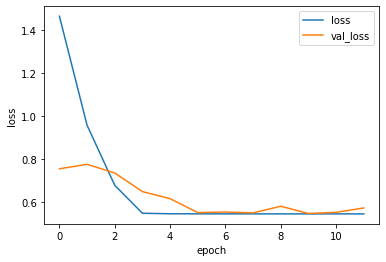

In [92]:
# train
AE01_history = ae01.train(x_train_removed, x_test, ae01_epochs, ae01_batch_size)

# plot training
AE01_hist_df = pd.DataFrame(AE01_history.history)

plt.figure()
AE01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [147]:
print(f'AE01 minimum validation loss is {min(AE01_history.history["val_loss"])}')

AE01 minimum validation loss is 0.5486856698989868


#### Train AE 02

In [11]:
# Batch Norm Model
def create_AE02_model(k_size):
    input_img = Input(shape=(32, 32, 64))  # 0
    conv1 = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE02_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE02_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE02_1")(conv1) # 3
    pool1 = MaxPooling2D(name="Pool_AE02_1")(conv1)  # 4
    
    unpool1 = UpSampling2D(name="Unpool_AE02_1")(pool1)  # 5
    decoded = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE02_2")(unpool1) # 6
    decoded = BatchNormalization(name="BN_AE02_2")(decoded) # 7
    decoded = Activation('relu', name="Relu_AE02_2")(decoded) # 8
    return Model(input_img, decoded)

In [119]:
class AE02():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE02_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE02_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE02_1').output)
        encode_model_path = '../models/AE/AE02_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history

In [99]:
# get encoded data
encoded_train01 = ae01.encoder.predict(x_train_removed)
encoded_test01 = ae01.encoder.predict(x_test)

In [122]:
# AE02 hyper prameters
ae02_epochs = 100
ae02_batch_size = 128
ae02_ksize = 3
ae02_optimizer = 'rmsprop'

# AE object
ae02 = AE02(ae02_ksize, ae02_optimizer)
ae02.compile()
ae02.autoencoder.summary()

Model: "functional_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 32, 32, 64)]      0         
_________________________________________________________________
Dense_AE02_1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
BN_AE02_1 (BatchNormalizatio (None, 32, 32, 128)       512       
_________________________________________________________________
Relu_AE02_1 (Activation)     (None, 32, 32, 128)       0         
_________________________________________________________________
Pool_AE02_1 (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
Unpool_AE02_1 (UpSampling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
Dense_AE02_2 (Conv2D)        (None, 32, 32, 64)     

Epoch 1/100
332/333 [============================>.] - ETA: 0s - loss: -0.6988
Epoch 00001: val_loss improved from inf to -0.86168, saving model to ../models/AE\AE02_AE_Best.hdf5
333/333 [==============================] - 201s 605ms/step - loss: -0.6988 - val_loss: -0.8617
Epoch 2/100
332/333 [============================>.] - ETA: 0s - loss: -1.0086
Epoch 00002: val_loss improved from -0.86168 to -0.93622, saving model to ../models/AE\AE02_AE_Best.hdf5
333/333 [==============================] - 199s 597ms/step - loss: -1.0086 - val_loss: -0.9362
Epoch 3/100
332/333 [============================>.] - ETA: 0s - loss: -1.0512
Epoch 00003: val_loss improved from -0.93622 to -1.02542, saving model to ../models/AE\AE02_AE_Best.hdf5
333/333 [==============================] - 200s 602ms/step - loss: -1.0512 - val_loss: -1.0254
Epoch 4/100
332/333 [============================>.] - ETA: 0s - loss: -1.0714
Epoch 00004: val_loss improved from -1.02542 to -1.03325, saving model to ../models/AE\AE

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

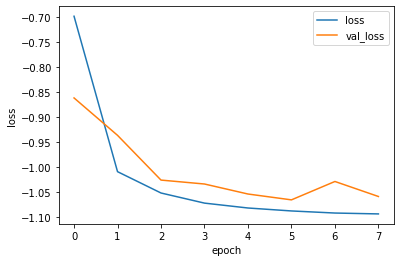

In [123]:
# train
AE02_history = ae02.train(encoded_train01, encoded_test01, ae02_epochs, ae02_batch_size)

# plot training
AE02_hist_df = pd.DataFrame(AE02_history.history)

plt.figure()
AE02_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [148]:
print(f'AE02 minimum validation loss is {min(AE02_history.history["val_loss"])}')

AE02 minimum validation loss is -1.0648534297943115


#### Train AE 03

In [15]:
# Batch Norm Model
def create_AE03_model(k_size):
    input_img = Input(shape=(16, 16, 128))  # 0
    conv1 = Conv2D(256, (k_size, k_size), padding='same', name="Dense_AE03_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE03_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE03_1")(conv1) # 3
    pool1 = MaxPooling2D(name="Pool_AE03_1")(conv1)  # 4
    
    unpool1 = UpSampling2D(name="Unpool_AE03_1")(pool1)  # 5
    decoded = Conv2D(128, (k_size, k_size), padding='same', name="Dense_AE03_2")(unpool1) # 6
    decoded = BatchNormalization(name="BN_AE03_2")(decoded) # 7
    decoded = Activation('relu', name="Relu_AE03_2")(decoded) # 8
    return Model(input_img, decoded)

In [16]:
class AE03():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE03_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE03_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Pool_AE03_1').output)
        encode_model_path = '../models/AE/AE03_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history

In [126]:
# get encoded data
encoded_train02 = ae02.encoder.predict(encoded_train01)
encoded_test02 = ae02.encoder.predict(encoded_test01)

In [17]:
# AE02 hyper prameters
ae03_epochs = 100
ae03_batch_size = 128
ae03_ksize = 3
ae03_optimizer = 'rmsprop'

# AE object
ae03 = AE03(ae03_ksize, ae03_optimizer)
ae03.compile()
ae03.autoencoder.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16, 16, 128)]     0         
_________________________________________________________________
Dense_AE03_1 (Conv2D)        (None, 16, 16, 256)       295168    
_________________________________________________________________
BN_AE03_1 (BatchNormalizatio (None, 16, 16, 256)       1024      
_________________________________________________________________
Relu_AE03_1 (Activation)     (None, 16, 16, 256)       0         
_________________________________________________________________
Pool_AE03_1 (MaxPooling2D)   (None, 8, 8, 256)         0         
_________________________________________________________________
Unpool_AE03_1 (UpSampling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
Dense_AE03_2 (Conv2D)        (None, 16, 16, 128)     

Epoch 1/100
332/333 [============================>.] - ETA: 0s - loss: -0.1945
Epoch 00001: val_loss improved from inf to -0.28474, saving model to ../models/AE\AE03_AE_Best.hdf5
333/333 [==============================] - 114s 341ms/step - loss: -0.1944 - val_loss: -0.2847
Epoch 2/100
332/333 [============================>.] - ETA: 0s - loss: -1.1481
Epoch 00002: val_loss improved from -0.28474 to -1.01379, saving model to ../models/AE\AE03_AE_Best.hdf5
333/333 [==============================] - 114s 341ms/step - loss: -1.1482 - val_loss: -1.0138
Epoch 3/100
332/333 [============================>.] - ETA: 0s - loss: -1.4631
Epoch 00003: val_loss improved from -1.01379 to -1.08215, saving model to ../models/AE\AE03_AE_Best.hdf5
333/333 [==============================] - 115s 346ms/step - loss: -1.4631 - val_loss: -1.0822
Epoch 4/100
332/333 [============================>.] - ETA: 0s - loss: -1.6280
Epoch 00004: val_loss improved from -1.08215 to -1.60028, saving model to ../models/AE\AE

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

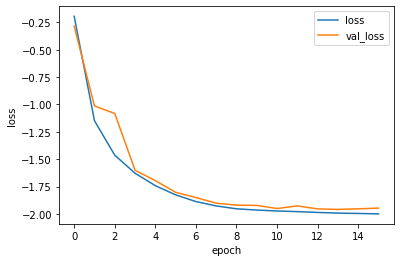

In [18]:
# train
AE03_history = ae03.train(encoded_train02, encoded_test02, ae03_epochs, ae03_batch_size)

# plot training
AE03_hist_df = pd.DataFrame(AE03_history.history)

plt.figure()
AE03_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [19]:
print(f'AE03 minimum validation loss is {min(AE03_history.history["val_loss"])}')

AE03 minimum validation loss is -1.9582256078720093
